### This example is almost equivalent to 04.Federated_Training. Here, we transform high and low values using the flooring and capping technique and perform inference using the final global model.

In [59]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [60]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch
import pandas as pd

from matplotlib import pyplot as plt

from argparse import Namespace

In [61]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [62]:
from ml.utils.train_utils import train, test

In [63]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [64]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [65]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset

    test_size=0.2, # validation size 
    targets=['temp','pH','DissolvedOxygen','Conductivity','Turbidity','AmmoniaNitrogen'], # the target columns    num_lags=10, # the number of past observations to feed as input
    num_lags=10, # the number of past observations to feed as input


    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=30, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [66]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(aggregation='fedavg', assign_stats=None, batch_size=128, criterion='mse', cuda=True, data_path='../dataset/full_dataset.csv', epochs=3, fl_rounds=30, fraction=1.0, identifier='District', local_early_stopping=False, local_patience=50, lr=0.001, max_grad_norm=0.0, nan_constant=0, num_lags=10, optimizer='adam', outlier_detection=True, reg1=0.0, reg2=0.0, seed=0, targets=['temp', 'pH', 'DissolvedOxygen', 'Conductivity', 'Turbidity', 'AmmoniaNitrogen'], test_size=0.2, use_time_features=False, x_scaler='minmax', y_scaler='minmax')



In [67]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [68]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['Conductivity', 'Turbidity', 'pH', 'DissolvedOxygen']
    outlier_kwargs = {"upstream": (10, 90), "midstream": (10, 90), "downstream": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [69]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [70]:
seed_all()

In [71]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets)
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [72]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers = make_preprocessing()

INFO logger 2024-06-03 08:18:16,569 | data_utils.py:383 | Observations info in upstream
INFO logger 2024-06-03 08:18:16,570 | data_utils.py:384 | 	Total number of samples:  4863
INFO logger 2024-06-03 08:18:16,570 | data_utils.py:385 | 	Number of samples for training: 3891
INFO logger 2024-06-03 08:18:16,571 | data_utils.py:386 | 	Number of samples for validation:  972
INFO logger 2024-06-03 08:18:16,574 | data_utils.py:383 | Observations info in midstream
INFO logger 2024-06-03 08:18:16,575 | data_utils.py:384 | 	Total number of samples:  4930
INFO logger 2024-06-03 08:18:16,575 | data_utils.py:385 | 	Number of samples for training: 3944
INFO logger 2024-06-03 08:18:16,576 | data_utils.py:386 | 	Number of samples for validation:  986
INFO logger 2024-06-03 08:18:16,578 | data_utils.py:383 | Observations info in downstream
INFO logger 2024-06-03 08:18:16,579 | data_utils.py:384 | 	Total number of samples:  4920
INFO logger 2024-06-03 08:18:16,579 | data_utils.py:385 | 	Number of sample

In [73]:
X_train.head()

,TotalNitrogen_lag-10,TotalPhosphorus_lag-10,AmmoniaNitrogen_lag-10,PermanganateIndex_lag-10,Turbidity_lag-10,Conductivity_lag-10,DissolvedOxygen_lag-10,pH_lag-10,temp_lag-10,TotalNitrogen_lag-9,...,TotalNitrogen_lag-1,TotalPhosphorus_lag-1,AmmoniaNitrogen_lag-1,PermanganateIndex_lag-1,Turbidity_lag-1,Conductivity_lag-1,DissolvedOxygen_lag-1,pH_lag-1,temp_lag-1,District
time,,,,,,,,,,,,,,,,,,,,,
2020-11-10 16:00:00,0.053548,0.487918,0.454747,0.202132,0.004721,0.104821,0.206544,0.117647,0.671883,0.053548,...,0.054376,0.490246,0.469831,0.184912,0.240793,0.119973,0.214724,0.113445,0.661090,upstream
2020-11-10 20:00:00,0.053548,0.487918,0.454747,0.202132,0.099150,0.103444,0.063395,0.058823,0.663788,0.052996,...,0.052996,0.490246,0.463620,0.191472,0.080264,0.146143,0.355828,0.180672,0.679978,upstream
2020-11-11 00:00:00,0.052996,0.489781,0.468944,0.179582,0.099150,0.103444,0.059305,0.058823,0.658392,0.054376,...,0.057137,0.492574,0.459184,0.181222,0.023607,0.136501,0.249489,0.121849,0.666487,upstream
2020-11-11 04:00:00,0.054376,0.489781,0.468944,0.188602,0.042493,0.117218,0.241309,0.155462,0.677280,0.055756,...,0.052720,0.488850,0.458740,0.187782,0.075543,0.124105,0.167689,0.079832,0.658392,upstream
2020-11-11 08:00:00,0.055756,0.488850,0.458740,0.192292,0.042493,0.117218,0.337423,0.155462,0.685375,0.055480,...,0.052720,0.488850,0.458740,0.187782,0.108593,0.119973,0.122699,0.067227,0.655693,upstream


In [74]:
y_train.head()

,temp,pH,DissolvedOxygen,Conductivity,Turbidity,AmmoniaNitrogen,District
time,,,,,,,
2020-11-10 16:00:00,0.679978,0.180672,0.355828,0.146143,0.080264,0.463620,upstream
2020-11-10 20:00:00,0.666487,0.121849,0.249489,0.136501,0.023607,0.459184,upstream
2020-11-11 00:00:00,0.658392,0.079832,0.167689,0.124105,0.075543,0.458740,upstream
2020-11-11 04:00:00,0.655693,0.067227,0.122699,0.119973,0.108593,0.458740,upstream
2020-11-11 08:00:00,0.652995,0.063025,0.110429,0.124105,0.203022,0.462733,upstream


In [75]:
x_scalers, y_scalers

({'upstream': MinMaxScaler(),
  'midstream': MinMaxScaler(),
  'downstream': MinMaxScaler()},
 {'upstream': MinMaxScaler(),
  'midstream': MinMaxScaler(),
  'downstream': MinMaxScaler()})

In [76]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [77]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)

In [78]:
x_scalers, y_scalers

({'upstream': MinMaxScaler(),
  'midstream': MinMaxScaler(),
  'downstream': MinMaxScaler()},
 {'upstream': MinMaxScaler(),
  'midstream': MinMaxScaler(),
  'downstream': MinMaxScaler()})

In [79]:
client_X_train.keys()

dict_keys(['upstream', 'midstream', 'downstream'])

In [80]:
client_X_val.keys()

dict_keys(['upstream', 'midstream', 'downstream'])

In [81]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: upstream
X_train shape: (3881, 10, 9, 1), y_train shape: (3881, 6)
X_val shape: (962, 10, 9, 1), y_val shape: (962, 6)

Client: midstream
X_train shape: (3934, 10, 9, 1), y_train shape: (3934, 6)
X_val shape: (976, 10, 9, 1), y_val shape: (976, 6)

Client: downstream
X_train shape: (3926, 10, 9, 1), y_train shape: (3926, 6)
X_val shape: (974, 10, 9, 1), y_val shape: (974, 6)


In [82]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [83]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [84]:
# define the model
args.model_name = "rnn"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                  exogenous_dim=exogenous_dim,
                  seed=args.seed)

9 0


In [85]:
model

RNN(
  (rnn): RNN(9, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [86]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[0,1,3,7,8,2], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=False
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = tmp_exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [87]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

In [88]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2024-06-03 08:18:17,261 | server.py:62 | Initializing client manager...
INFO logger 2024-06-03 08:18:17,262 | server.py:69 | Registering clients...
INFO logger 2024-06-03 08:18:17,262 | client_manager.py:66 | Registered client with id: upstream
INFO logger 2024-06-03 08:18:17,263 | client_manager.py:66 | Registered client with id: midstream
INFO logger 2024-06-03 08:18:17,264 | client_manager.py:66 | Registered client with id: downstream
INFO logger 2024-06-03 08:18:17,264 | server.py:73 | Client manager initialized!
INFO logger 2024-06-03 08:18:17,264 | server.py:55 | Aggregation algorithm: FedAvg()
INFO logger 2024-06-03 08:18:17,265 | client_manager.py:88 | Parameter c=0.0. Sampled 1 client(s): ['midstream']
INFO logger 2024-06-03 08:18:17,845 | server.py:86 | Starting FL rounds
INFO logger 2024-06-03 08:18:17,845 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['midstream', 'upstream', 'downstream']
INFO logger 2024-06-03 08:18:19,578 | train_utils.py:142

In [89]:
history


History (client, train losses):
	midstream: {1: 0.00020193829767909763, 2: 0.00015941359070529779, 3: 0.00016858939073854858, 4: 0.00014337084038788193, 5: 0.0001250498264793157, 6: 0.00012217844534811176, 7: 0.00012347226002242702, 8: 0.0001231739512939682, 9: 0.00012053506274626651, 10: 0.00012507688241807652, 11: 0.00011209235384579262, 12: 0.00012799106745677185, 13: 0.0001199669628411183, 14: 0.00011547154819864607, 15: 0.0001186961537756378, 16: 0.00011768037061257658, 17: 0.00011863597101959469, 18: 0.00011964419138881538, 19: 0.00011713831850252268, 20: 0.0001165745917179285, 21: 0.00011522795976128715, 22: 9.869256998584182e-05, 23: 0.00010965508811297032, 24: 0.00011026178854534211, 25: 0.00011088978215089956, 26: 0.00011212541082571865, 27: 0.00011178319227380321, 28: 0.00011241130791718153, 29: 0.00010928334729830263, 30: 0.00011141694623865207}
	upstream: {1: 0.00021478449011495574, 2: 0.00017479759240482187, 3: 0.00014569263097068694, 4: 0.00010141513591857338, 5: 9.0771

In [90]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [91]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

### During the inference stage we inverse the transformations we applied during preprocessing

In [92]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scalers used to transform the targets
    idxs=[0,1,3,7,8,2], # the indices of our targets in X
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)

Prediction on upstream
Prediction on midstream
Prediction on downstream


INFO logger 2024-06-03 08:19:35,910 | helpers.py:60 | Metrics for dimension: 0
	mse: 1.5003193616867065, rmse: 1.2248752433152963, mae: 0.8094927668571472, r^2: 0.9411394736940876, nrmse: 0.04834252651549984
INFO logger 2024-06-03 08:19:35,912 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.08797594904899597, rmse: 0.29660739884398696, mae: 0.21550971269607544, r^2: 0.8509702035734475, nrmse: 0.04071921496327367
INFO logger 2024-06-03 08:19:35,913 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.0734537839889526, rmse: 1.0360761477753229, mae: 0.7725403308868408, r^2: 0.7792779264526993, nrmse: 0.15164666347056902
INFO logger 2024-06-03 08:19:35,916 | helpers.py:60 | Metrics for dimension: 3
	mse: 1335224.75, rmse: 1155.5192555730086, mae: 911.0021362304688, r^2: 0.9188205681134242, nrmse: 0.17520545691195977
INFO logger 2024-06-03 08:19:35,918 | helpers.py:60 | Metrics for dimension: 4
	mse: 6.144883632659912, rmse: 2.4788875796735743, mae: 1.71803617477417, r^2: 0.88797035683688


Final Prediction on upstream (Inference Stage)
[Train]: mse: 222538.546875, rmse: 471.73991443909006, mae 152.46633911132812, r2: 0.7078544993351841, nrmse: 0.27858513180298666
[Val]: mse: 301851.71875, rmse: 549.4103373162905, mae 143.25514221191406, r2: 0.7599607495754225, nrmse: 0.5016782193376884




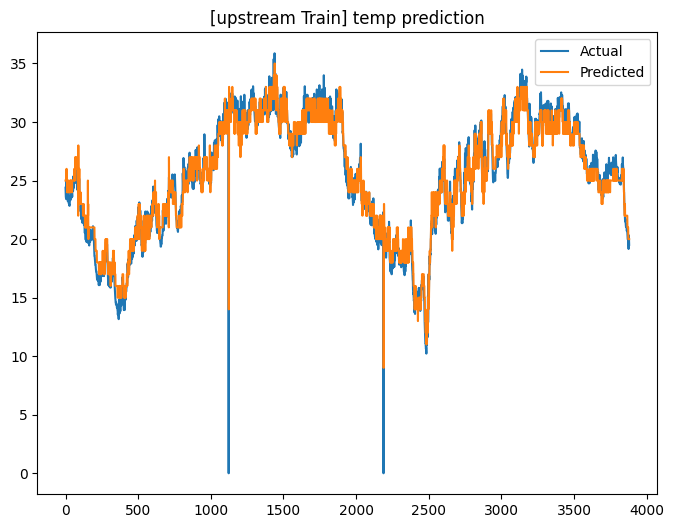

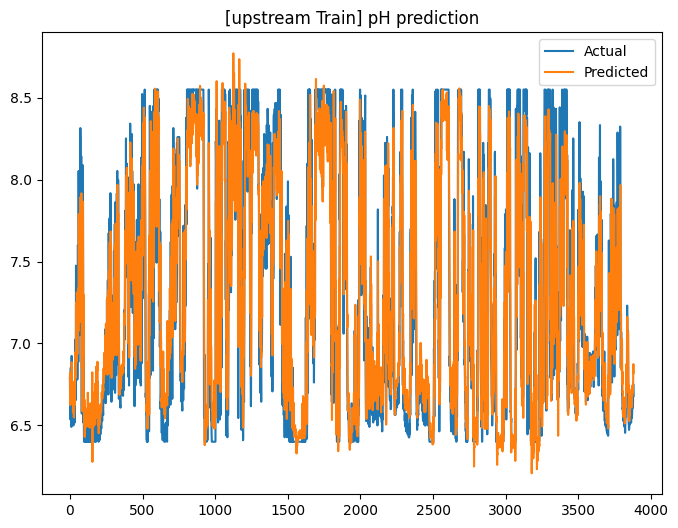

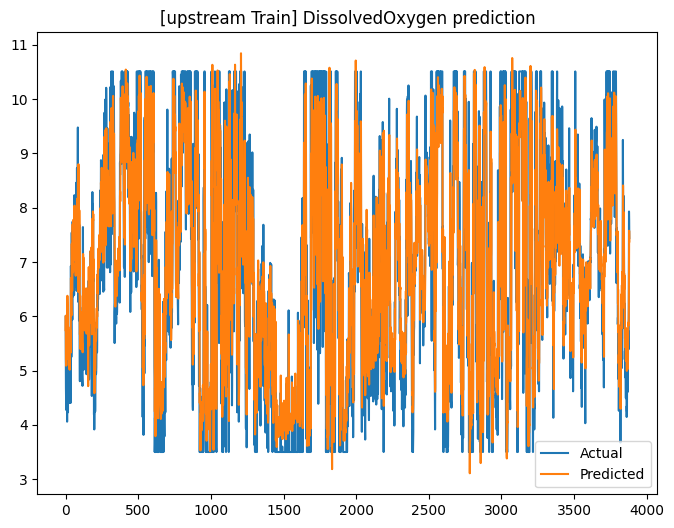

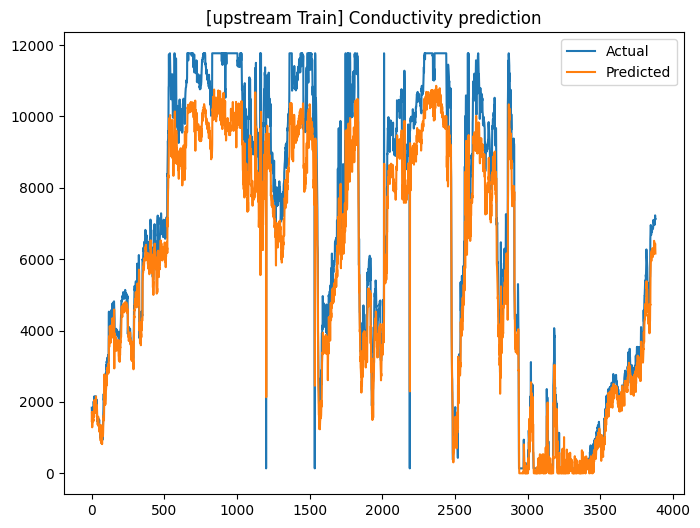

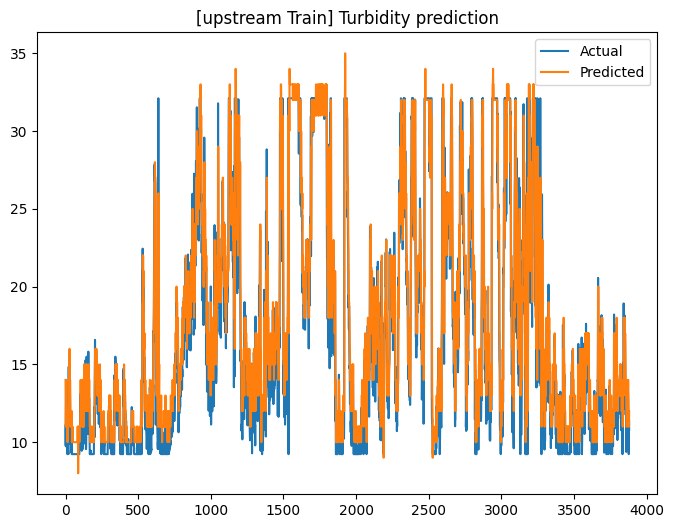

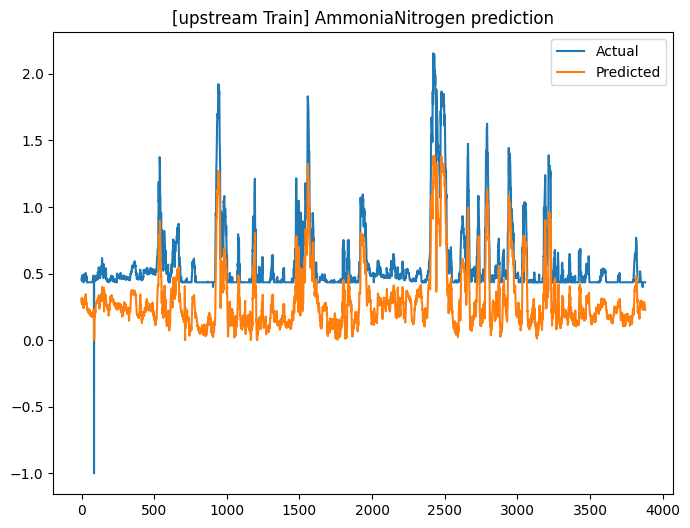

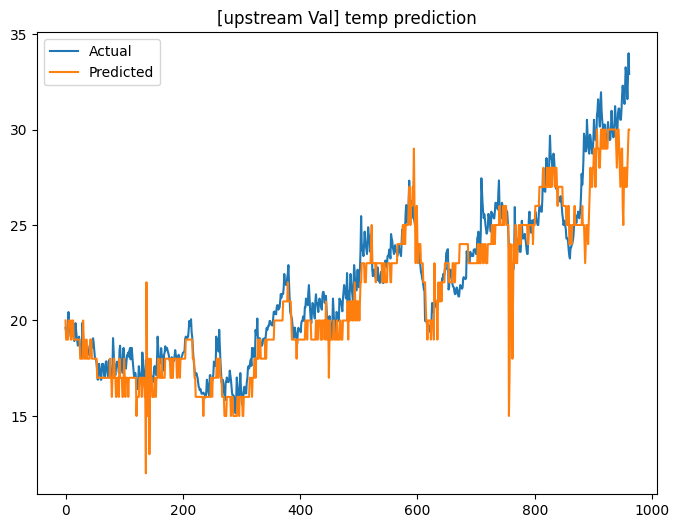

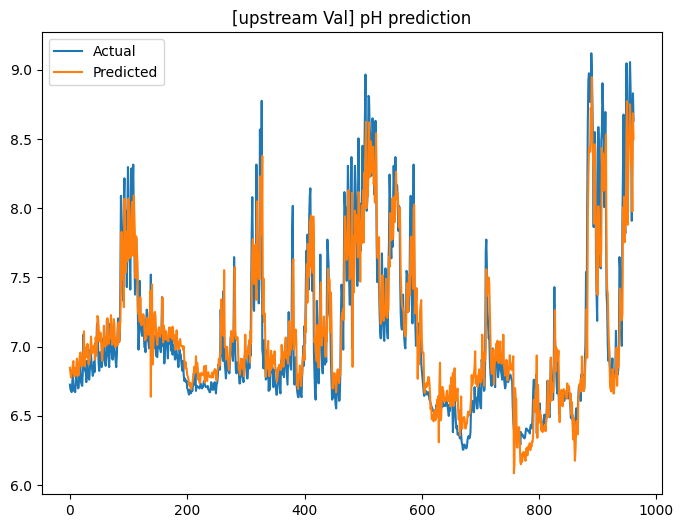

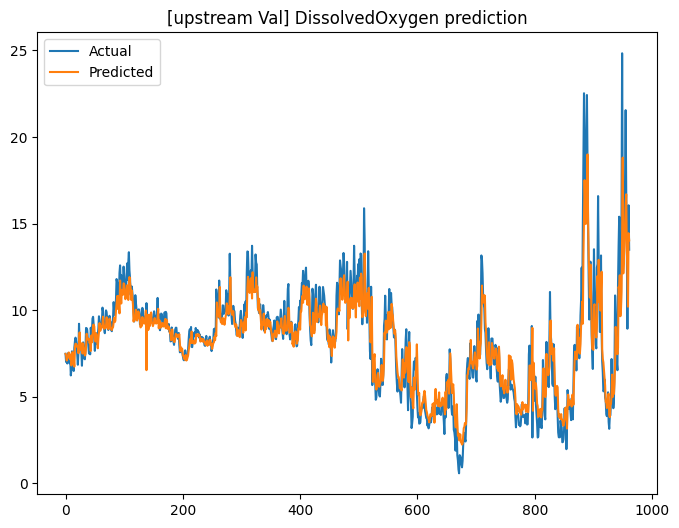

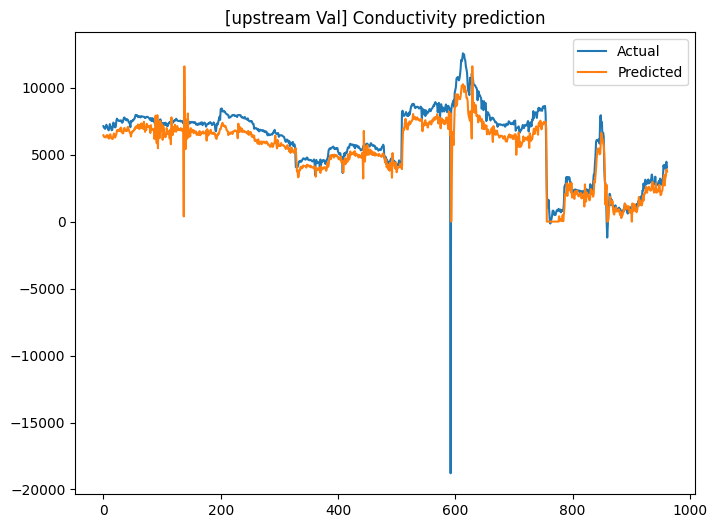

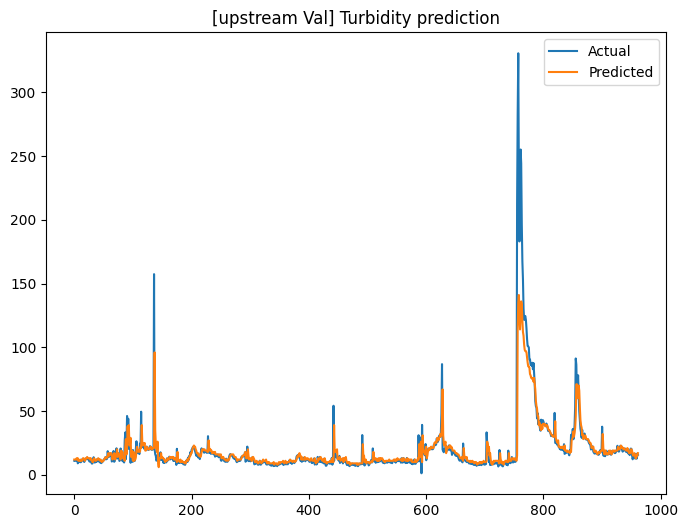

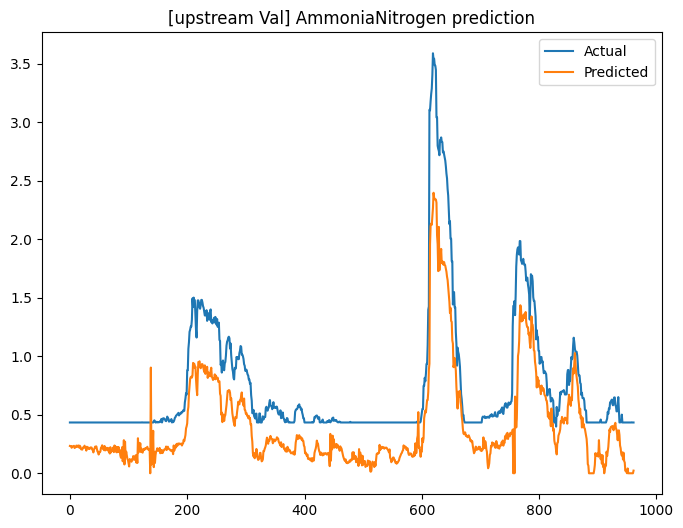

INFO logger 2024-06-03 08:19:37,520 | helpers.py:60 | Metrics for dimension: 0
	mse: 8.231539726257324, rmse: 2.8690660024226218, mae: 2.6052801609039307, r^2: 0.873013690743131, nrmse: 0.1362049672764176
INFO logger 2024-06-03 08:19:37,522 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.16965875029563904, rmse: 0.41189652862780846, mae: 0.3267250657081604, r^2: 0.6244708356674927, nrmse: 0.05637488402291503
INFO logger 2024-06-03 08:19:37,523 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.3652046918869019, rmse: 1.1684197413117008, mae: 0.9089064002037048, r^2: 0.7346209291750954, nrmse: 0.1690925037301124
INFO logger 2024-06-03 08:19:37,524 | helpers.py:60 | Metrics for dimension: 3
	mse: 1367863.5, rmse: 1169.5569674026144, mae: 914.547607421875, r^2: 0.8944063093939176, nrmse: 0.18337019764231122
INFO logger 2024-06-03 08:19:37,526 | helpers.py:60 | Metrics for dimension: 4
	mse: 9.798914909362793, rmse: 3.13032185395732, mae: 2.392080545425415, r^2: 0.810780043029653, nrmse


Final Prediction on midstream (Inference Stage)
[Train]: mse: 227980.328125, rmse: 477.4728559038723, mae 153.60360717773438, r2: -0.755725027491207, nrmse: -0.22930510229892073
[Val]: mse: 213793.828125, rmse: 462.3784468646868, mae 131.58509826660156, r2: -0.1522856586395577, nrmse: -0.22912663933188426




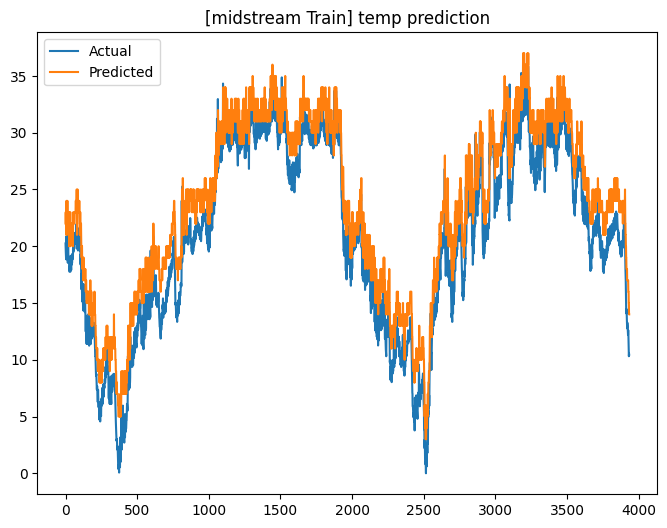

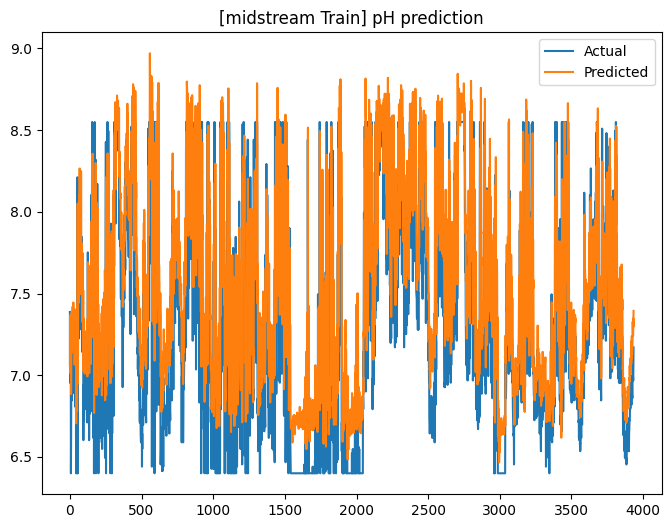

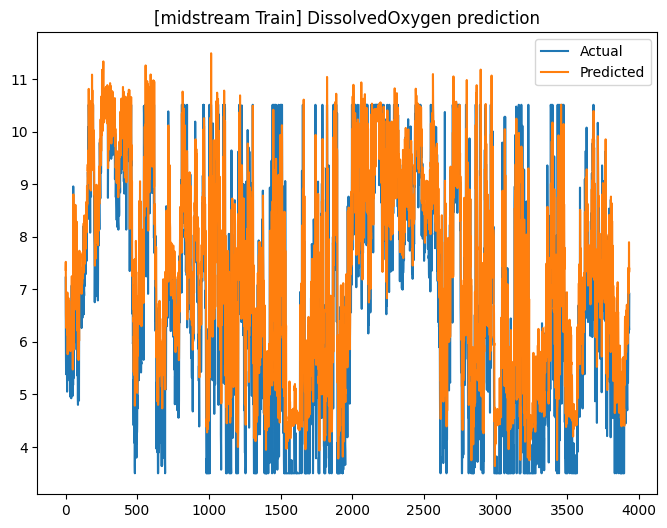

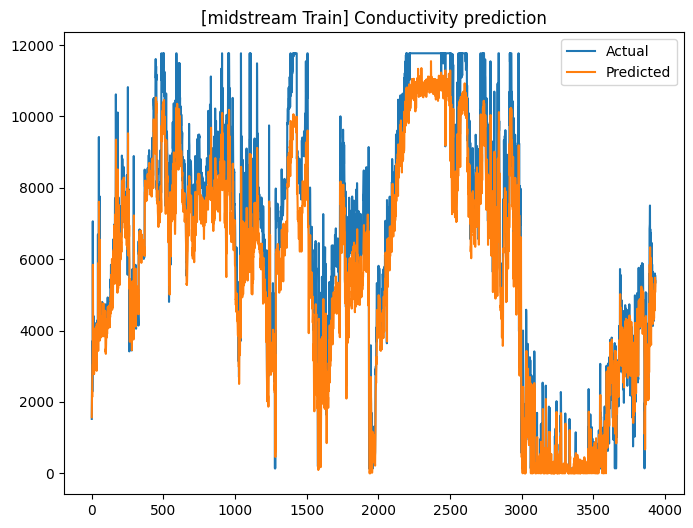

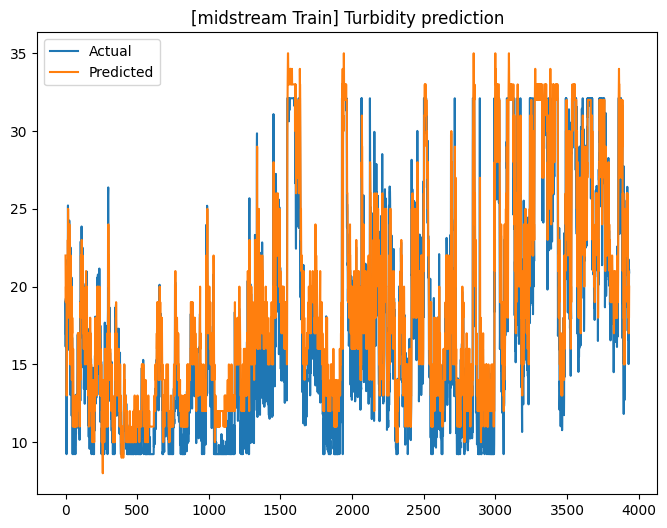

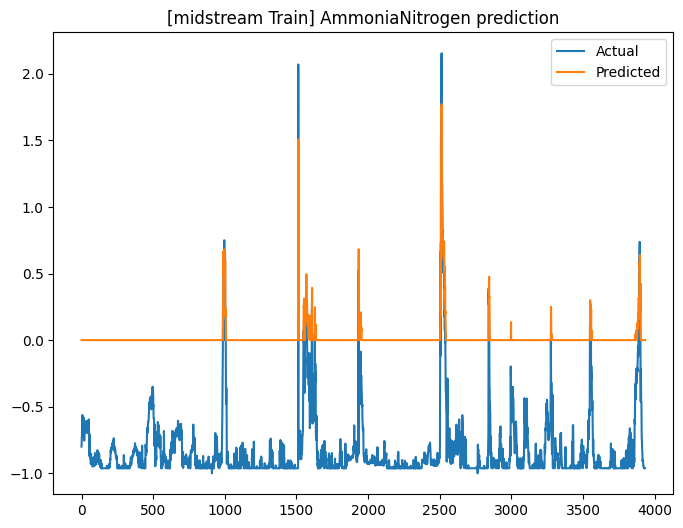

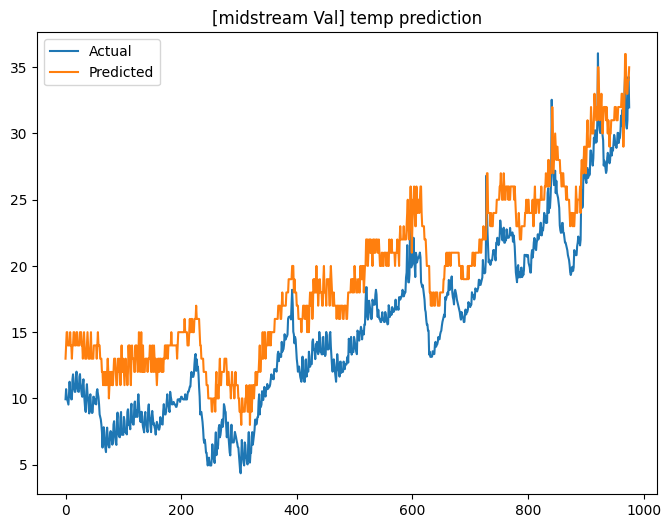

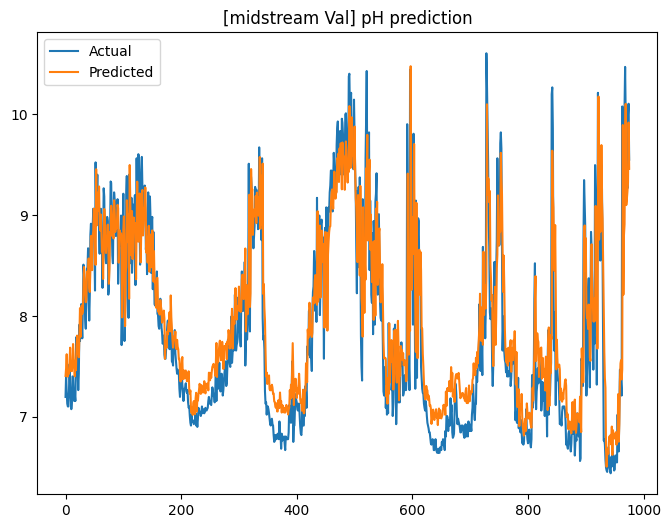

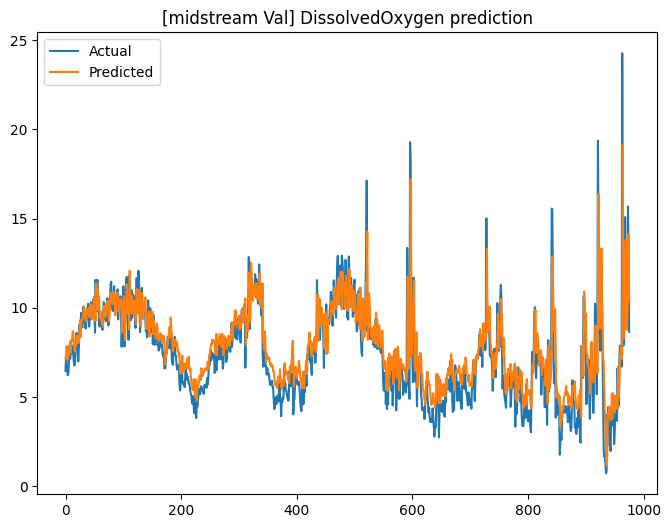

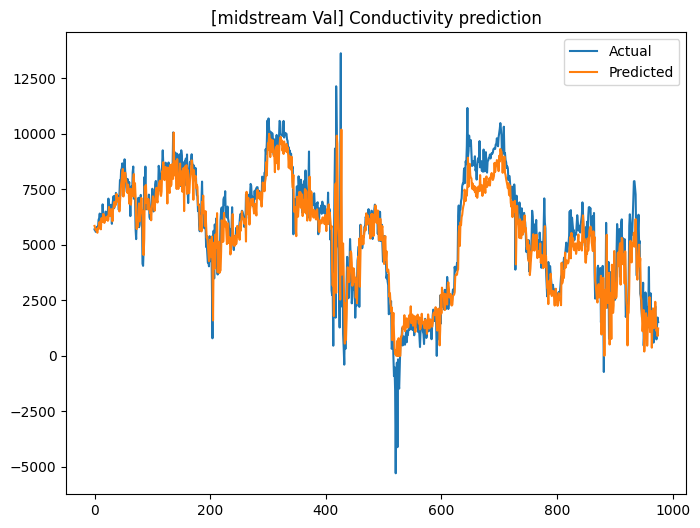

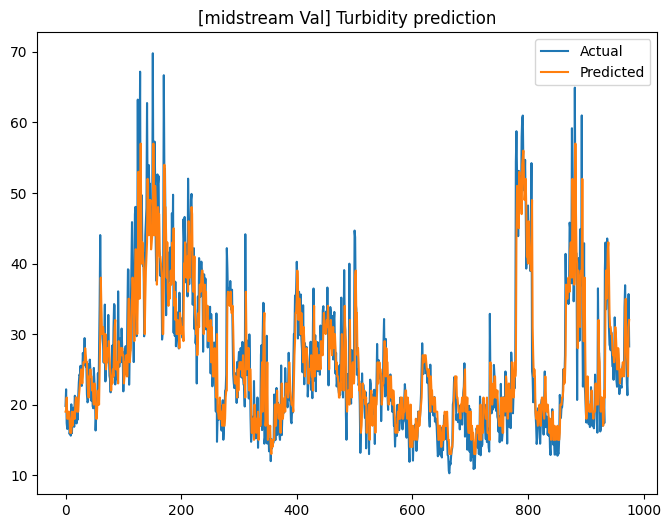

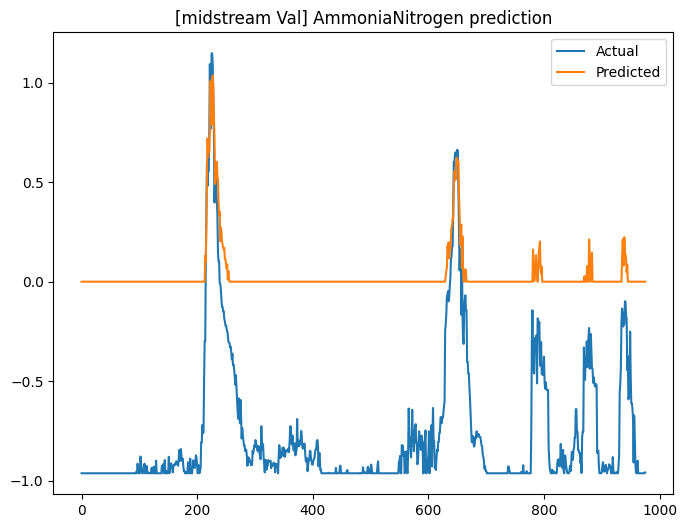

INFO logger 2024-06-03 08:19:39,103 | helpers.py:60 | Metrics for dimension: 0
	mse: 1.5332248210906982, rmse: 1.2382345581878653, mae: 0.8629037737846375, r^2: 0.9352216100296902, nrmse: 0.04709649234230917
INFO logger 2024-06-03 08:19:39,105 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.1357140839099884, rmse: 0.3683939249091771, mae: 0.24588672816753387, r^2: 0.5951618180467984, nrmse: 0.05088582489253839
INFO logger 2024-06-03 08:19:39,107 | helpers.py:60 | Metrics for dimension: 2
	mse: 1.447885274887085, rmse: 1.2032810456776442, mae: 0.890314519405365, r^2: 0.627252701533009, nrmse: 0.17589253966422072
INFO logger 2024-06-03 08:19:39,108 | helpers.py:60 | Metrics for dimension: 3
	mse: 4920202.5, rmse: 2218.152947837457, mae: 1141.288818359375, r^2: 0.5767006900216962, nrmse: 1.233836267947382
INFO logger 2024-06-03 08:19:39,110 | helpers.py:60 | Metrics for dimension: 4
	mse: 11.168662071228027, rmse: 3.3419548278257785, mae: 2.392885208129883, r^2: 0.6475920158002694, nrm


Final Prediction on downstream (Inference Stage)
[Train]: mse: 820033.4375, rmse: 905.556976396295, mae 190.9584197998047, r2: 0.675992767950623, nrmse: 0.7108805424770867
[Val]: mse: 56743.375, rmse: 238.20867952280832, mae 49.84603500366211, r2: 0.697965910672341, nrmse: 0.7996913980400279




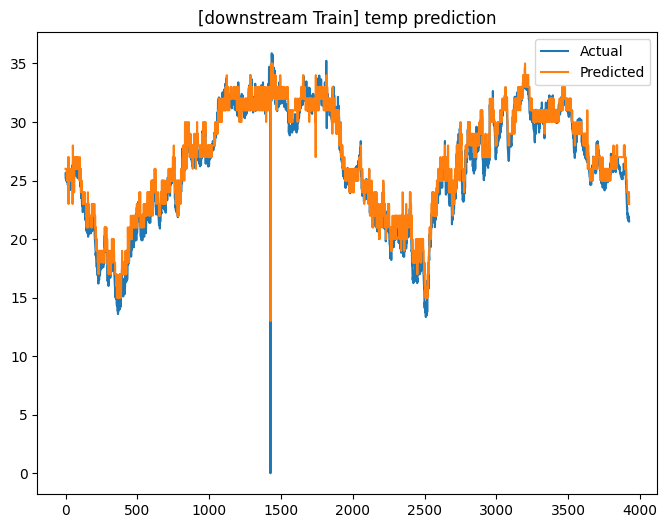

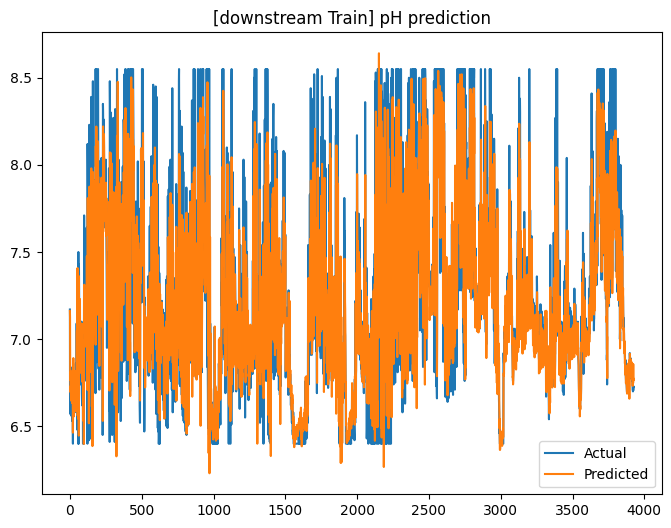

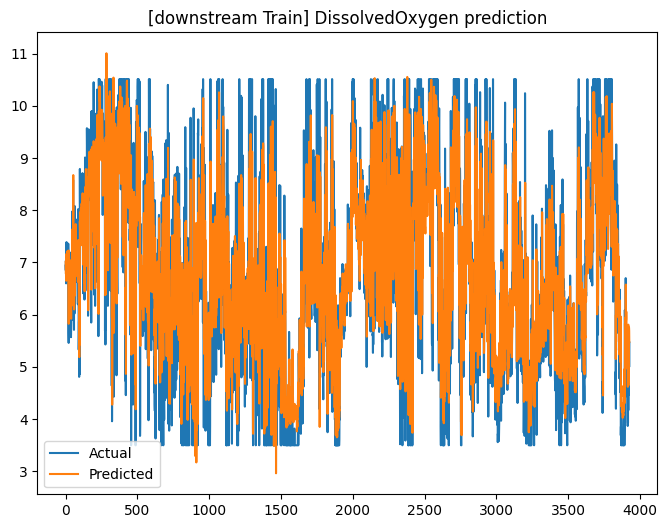

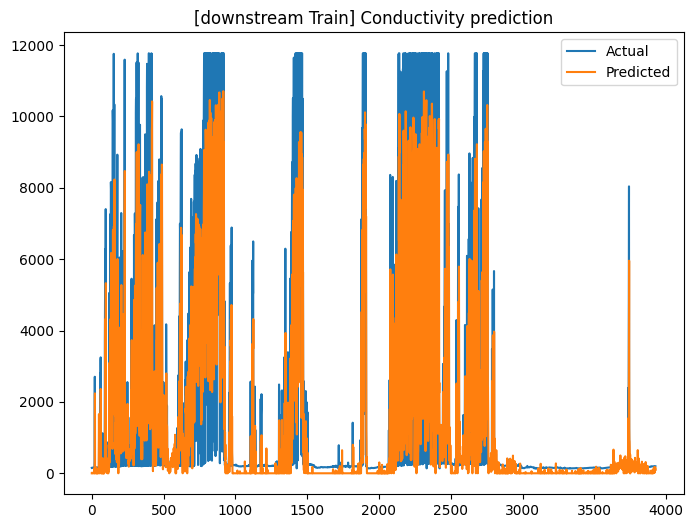

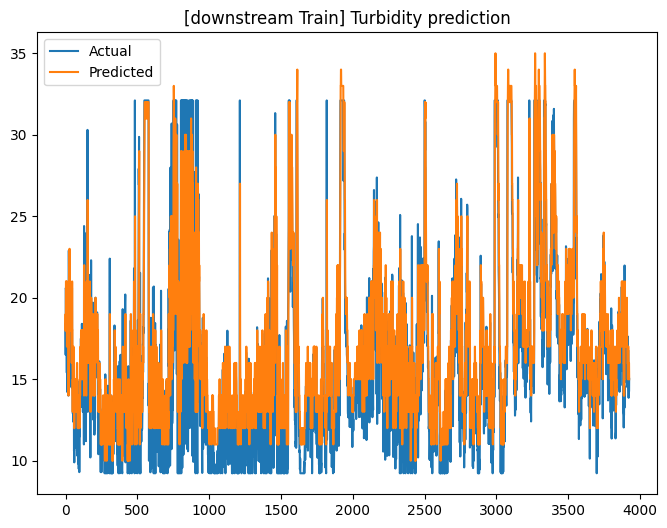

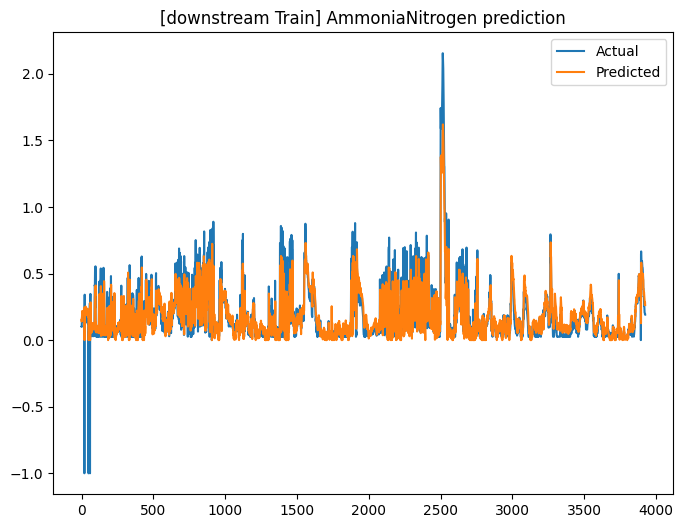

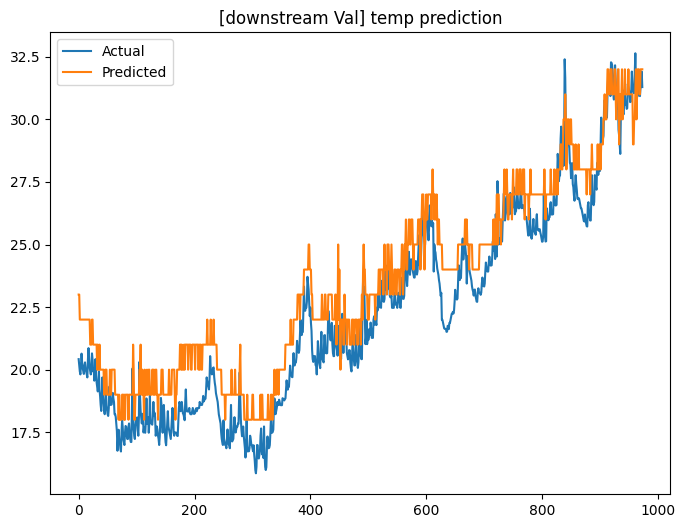

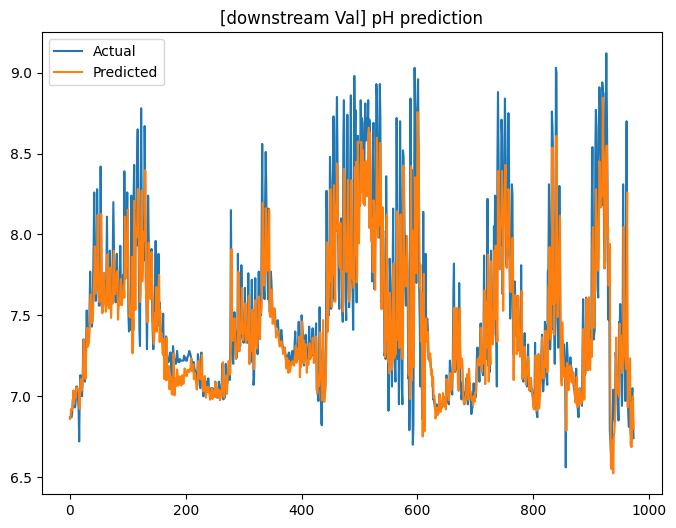

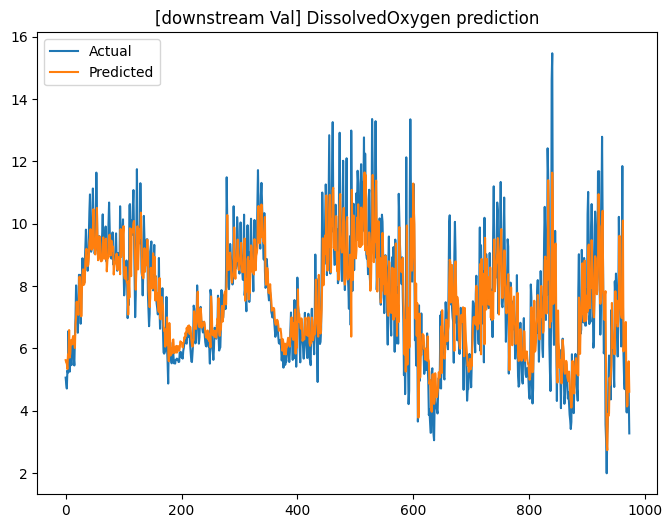

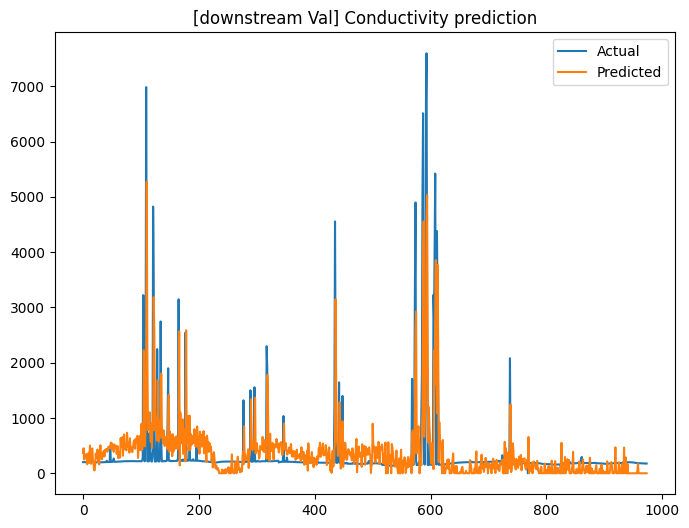

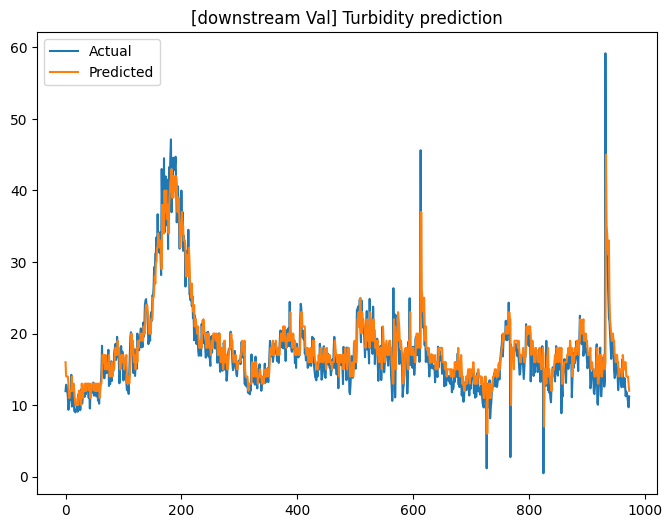

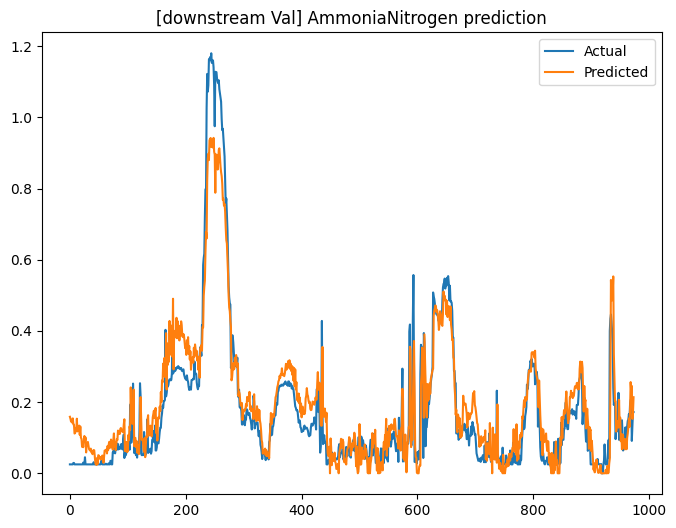

In [93]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scalers
)